In [ ]:
student_id = '20224258'
model_name = 'LCNet'

In [2]:
from competition_utils import *
from training_args import *

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                    #  'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


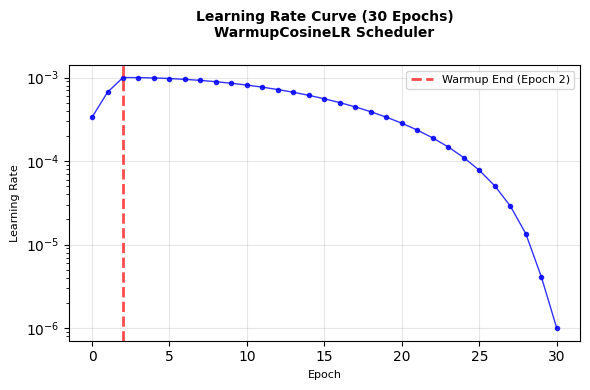


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250616_184055
Dataset: ETIS (1/4)
train/val/test: 118/39/39
submission_LCNet Dataset: ETIS) (1/4) Training Start Time: 250616_184055


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

1EP(250616_184057): T_Loss: 0.960042 V_Loss: 0.955611 IoU: 0.0387 Best Epoch: 1 Loss: 0.955611


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

2EP(250616_184058): T_Loss: 0.959008 V_Loss: 0.955466 IoU: 0.0448 Best Epoch: 2 Loss: 0.955466


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

3EP(250616_184100): T_Loss: 0.957656 V_Loss: 0.968088 IoU: 0.0446 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

4EP(250616_184101): T_Loss: 0.954886 V_Loss: 0.966694 IoU: 0.0429 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

5EP(250616_184102): T_Loss: 0.952121 V_Loss: 0.954330 IoU: 0.0442 Best Epoch: 5 Loss: 0.954330


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

6EP(250616_184103): T_Loss: 0.949568 V_Loss: 0.952842 IoU: 0.0500 Best Epoch: 6 Loss: 0.952842


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

7EP(250616_184105): T_Loss: 0.947952 V_Loss: 0.957954 IoU: 0.0550 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

8EP(250616_184106): T_Loss: 0.946019 V_Loss: 0.959781 IoU: 0.0569 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

9EP(250616_184107): T_Loss: 0.943412 V_Loss: 0.961180 IoU: 0.0584 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

10EP(250616_184109): T_Loss: 0.941420 V_Loss: 0.960264 IoU: 0.0592 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

11EP(250616_184110): T_Loss: 0.940251 V_Loss: 0.958231 IoU: 0.0607 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

12EP(250616_184111): T_Loss: 0.936334 V_Loss: 0.954181 IoU: 0.0611 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

13EP(250616_184112): T_Loss: 0.935728 V_Loss: 0.950721 IoU: 0.0620 Best Epoch: 13 Loss: 0.950721


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

14EP(250616_184114): T_Loss: 0.933525 V_Loss: 0.949313 IoU: 0.0622 Best Epoch: 14 Loss: 0.949313


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

15EP(250616_184115): T_Loss: 0.932636 V_Loss: 0.949045 IoU: 0.0616 Best Epoch: 15 Loss: 0.949045


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

16EP(250616_184116): T_Loss: 0.930805 V_Loss: 0.948370 IoU: 0.0617 Best Epoch: 16 Loss: 0.948370


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

17EP(250616_184118): T_Loss: 0.929493 V_Loss: 0.946582 IoU: 0.0619 Best Epoch: 17 Loss: 0.946582


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

18EP(250616_184119): T_Loss: 0.929843 V_Loss: 0.946920 IoU: 0.0621 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

19EP(250616_184120): T_Loss: 0.928875 V_Loss: 0.946095 IoU: 0.0626 Best Epoch: 19 Loss: 0.946095


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

20EP(250616_184122): T_Loss: 0.927516 V_Loss: 0.944136 IoU: 0.0632 Best Epoch: 20 Loss: 0.944136


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

21EP(250616_184123): T_Loss: 0.926799 V_Loss: 0.944692 IoU: 0.0635 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

22EP(250616_184124): T_Loss: 0.926361 V_Loss: 0.942587 IoU: 0.0636 Best Epoch: 22 Loss: 0.942587


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

23EP(250616_184126): T_Loss: 0.926181 V_Loss: 0.940693 IoU: 0.0638 Best Epoch: 23 Loss: 0.940693


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

24EP(250616_184127): T_Loss: 0.925975 V_Loss: 0.940617 IoU: 0.0639 Best Epoch: 24 Loss: 0.940617


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

25EP(250616_184128): T_Loss: 0.926199 V_Loss: 0.940410 IoU: 0.0640 Best Epoch: 25 Loss: 0.940410


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

26EP(250616_184130): T_Loss: 0.925624 V_Loss: 0.943235 IoU: 0.0641 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

27EP(250616_184131): T_Loss: 0.927516 V_Loss: 0.942431 IoU: 0.0642 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

28EP(250616_184132): T_Loss: 0.925639 V_Loss: 0.942328 IoU: 0.0641 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

29EP(250616_184133): T_Loss: 0.925976 V_Loss: 0.941523 IoU: 0.0642 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

30EP(250616_184135): T_Loss: 0.924720 V_Loss: 0.942588 IoU: 0.0641 
Test Start Time: 250616_184135


Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Best Epoch: 25
Test(250616_184146): Loss: 0.921684 IoU: 0.0745 Dice: 0.1272 Precision: 0.0826 Recall: 0.5469
End 250616_184146
Dataset: CVPPP (2/4)
train/val/test: 486/162/162
submission_LCNet Dataset: CVPPP) (2/4) Training Start Time: 250616_184146


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

1EP(250616_184150): T_Loss: 0.880924 V_Loss: 0.912971 IoU: 0.2253 Best Epoch: 1 Loss: 0.912971


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

2EP(250616_184153): T_Loss: 0.848194 V_Loss: 0.848919 IoU: 0.3022 Best Epoch: 2 Loss: 0.848919


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

3EP(250616_184157): T_Loss: 0.836070 V_Loss: 0.822048 IoU: 0.3950 Best Epoch: 3 Loss: 0.822048


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

4EP(250616_184201): T_Loss: 0.825873 V_Loss: 0.813563 IoU: 0.4455 Best Epoch: 4 Loss: 0.813563


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

5EP(250616_184204): T_Loss: 0.821229 V_Loss: 0.809052 IoU: 0.4755 Best Epoch: 5 Loss: 0.809052


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

6EP(250616_184208): T_Loss: 0.815314 V_Loss: 0.807168 IoU: 0.4903 Best Epoch: 6 Loss: 0.807168


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

7EP(250616_184212): T_Loss: 0.811056 V_Loss: 0.804121 IoU: 0.5087 Best Epoch: 7 Loss: 0.804121


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

8EP(250616_184216): T_Loss: 0.805378 V_Loss: 0.798768 IoU: 0.5365 Best Epoch: 8 Loss: 0.798768


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

9EP(250616_184219): T_Loss: 0.803009 V_Loss: 0.800959 IoU: 0.5200 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

10EP(250616_184223): T_Loss: 0.800024 V_Loss: 0.792592 IoU: 0.5702 Best Epoch: 10 Loss: 0.792592


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

11EP(250616_184227): T_Loss: 0.795995 V_Loss: 0.790103 IoU: 0.5821 Best Epoch: 11 Loss: 0.790103


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

12EP(250616_184230): T_Loss: 0.795023 V_Loss: 0.788569 IoU: 0.5877 Best Epoch: 12 Loss: 0.788569


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

13EP(250616_184234): T_Loss: 0.792255 V_Loss: 0.786037 IoU: 0.6010 Best Epoch: 13 Loss: 0.786037


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

14EP(250616_184238): T_Loss: 0.789203 V_Loss: 0.785899 IoU: 0.5965 Best Epoch: 14 Loss: 0.785899


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

15EP(250616_184242): T_Loss: 0.787862 V_Loss: 0.782233 IoU: 0.6198 Best Epoch: 15 Loss: 0.782233


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

16EP(250616_184245): T_Loss: 0.787703 V_Loss: 0.781794 IoU: 0.6173 Best Epoch: 16 Loss: 0.781794


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

17EP(250616_184249): T_Loss: 0.783474 V_Loss: 0.781093 IoU: 0.6252 Best Epoch: 17 Loss: 0.781093


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

18EP(250616_184253): T_Loss: 0.784560 V_Loss: 0.777858 IoU: 0.6467 Best Epoch: 18 Loss: 0.777858


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

19EP(250616_184256): T_Loss: 0.782616 V_Loss: 0.777235 IoU: 0.6473 Best Epoch: 19 Loss: 0.777235


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

20EP(250616_184300): T_Loss: 0.780910 V_Loss: 0.777972 IoU: 0.6420 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

21EP(250616_184304): T_Loss: 0.781435 V_Loss: 0.778160 IoU: 0.6361 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

22EP(250616_184307): T_Loss: 0.781263 V_Loss: 0.776526 IoU: 0.6476 Best Epoch: 22 Loss: 0.776526


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

23EP(250616_184311): T_Loss: 0.779904 V_Loss: 0.778199 IoU: 0.6322 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

24EP(250616_184315): T_Loss: 0.782613 V_Loss: 0.776249 IoU: 0.6433 Best Epoch: 24 Loss: 0.776249


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

25EP(250616_184318): T_Loss: 0.780501 V_Loss: 0.774165 IoU: 0.6612 Best Epoch: 25 Loss: 0.774165


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

26EP(250616_184322): T_Loss: 0.780144 V_Loss: 0.775435 IoU: 0.6530 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

27EP(250616_184326): T_Loss: 0.778372 V_Loss: 0.775672 IoU: 0.6525 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

28EP(250616_184330): T_Loss: 0.779727 V_Loss: 0.773856 IoU: 0.6611 Best Epoch: 28 Loss: 0.773856


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

29EP(250616_184333): T_Loss: 0.778969 V_Loss: 0.774133 IoU: 0.6615 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

30EP(250616_184337): T_Loss: 0.779087 V_Loss: 0.774254 IoU: 0.6601 
Test Start Time: 250616_184337


Test:   0%|          | 0/11 [00:00<?, ?batch/s]

Best Epoch: 28
Test(250616_184424): Loss: 0.775883 IoU: 0.6393 Dice: 0.7591 Precision: 0.6698 Recall: 0.9119
End 250616_184424
Dataset: CFD (3/4)
train/val/test: 70/24/24
submission_LCNet Dataset: CFD) (3/4) Training Start Time: 250616_184424


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

1EP(250616_184425): T_Loss: 0.971410 V_Loss: 0.970701 IoU: 0.0105 Best Epoch: 1 Loss: 0.970701


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

2EP(250616_184426): T_Loss: 0.971368 V_Loss: 0.965760 IoU: 0.0086 Best Epoch: 2 Loss: 0.965760


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

3EP(250616_184427): T_Loss: 0.970384 V_Loss: 0.966019 IoU: 0.0101 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

4EP(250616_184428): T_Loss: 0.969656 V_Loss: 0.978833 IoU: 0.0105 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

5EP(250616_184429): T_Loss: 0.968557 V_Loss: 0.995032 IoU: 0.0107 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

6EP(250616_184430): T_Loss: 0.967688 V_Loss: 1.006230 IoU: 0.0108 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

7EP(250616_184431): T_Loss: 0.966284 V_Loss: 1.009919 IoU: 0.0107 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

8EP(250616_184432): T_Loss: 0.965206 V_Loss: 1.008451 IoU: 0.0103 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

9EP(250616_184433): T_Loss: 0.963881 V_Loss: 1.001870 IoU: 0.0103 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

10EP(250616_184434): T_Loss: 0.962773 V_Loss: 0.991969 IoU: 0.0102 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

11EP(250616_184436): T_Loss: 0.960847 V_Loss: 0.981043 IoU: 0.0101 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

12EP(250616_184437): T_Loss: 0.959587 V_Loss: 0.971450 IoU: 0.0103 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

13EP(250616_184438): T_Loss: 0.958510 V_Loss: 0.964482 IoU: 0.0103 Best Epoch: 13 Loss: 0.964482


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

14EP(250616_184439): T_Loss: 0.956891 V_Loss: 0.960163 IoU: 0.0105 Best Epoch: 14 Loss: 0.960163


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

15EP(250616_184440): T_Loss: 0.955646 V_Loss: 0.956625 IoU: 0.0106 Best Epoch: 15 Loss: 0.956625


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

16EP(250616_184441): T_Loss: 0.954664 V_Loss: 0.954550 IoU: 0.0109 Best Epoch: 16 Loss: 0.954550


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

17EP(250616_184442): T_Loss: 0.953608 V_Loss: 0.953446 IoU: 0.0109 Best Epoch: 17 Loss: 0.953446


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

18EP(250616_184443): T_Loss: 0.952821 V_Loss: 0.952319 IoU: 0.0110 Best Epoch: 18 Loss: 0.952319


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

19EP(250616_184444): T_Loss: 0.951909 V_Loss: 0.951250 IoU: 0.0111 Best Epoch: 19 Loss: 0.951250


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

20EP(250616_184445): T_Loss: 0.951172 V_Loss: 0.950669 IoU: 0.0112 Best Epoch: 20 Loss: 0.950669


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

21EP(250616_184447): T_Loss: 0.950323 V_Loss: 0.949903 IoU: 0.0112 Best Epoch: 21 Loss: 0.949903


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

22EP(250616_184448): T_Loss: 0.949783 V_Loss: 0.949365 IoU: 0.0112 Best Epoch: 22 Loss: 0.949365


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

23EP(250616_184449): T_Loss: 0.949586 V_Loss: 0.949113 IoU: 0.0113 Best Epoch: 23 Loss: 0.949113


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

24EP(250616_184450): T_Loss: 0.949094 V_Loss: 0.949109 IoU: 0.0113 Best Epoch: 24 Loss: 0.949109


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

25EP(250616_184451): T_Loss: 0.949073 V_Loss: 0.948936 IoU: 0.0113 Best Epoch: 25 Loss: 0.948936


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

26EP(250616_184452): T_Loss: 0.949096 V_Loss: 0.948844 IoU: 0.0113 Best Epoch: 26 Loss: 0.948844


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

27EP(250616_184453): T_Loss: 0.948545 V_Loss: 0.948509 IoU: 0.0113 Best Epoch: 27 Loss: 0.948509


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

28EP(250616_184454): T_Loss: 0.948634 V_Loss: 0.948413 IoU: 0.0113 Best Epoch: 28 Loss: 0.948413


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

29EP(250616_184456): T_Loss: 0.948426 V_Loss: 0.948229 IoU: 0.0113 Best Epoch: 29 Loss: 0.948229


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

30EP(250616_184457): T_Loss: 0.948408 V_Loss: 0.948174 IoU: 0.0112 Best Epoch: 30 Loss: 0.948174
Test Start Time: 250616_184457


Test:   0%|          | 0/2 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250616_184504): Loss: 0.942742 IoU: 0.0136 Dice: 0.0266 Precision: 0.0141 Recall: 0.3825
End 250616_184504
Dataset: CarDD (4/4)
train/val/test: 310/104/104
submission_LCNet Dataset: CarDD) (4/4) Training Start Time: 250616_184504


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

1EP(250616_184507): T_Loss: 0.921639 V_Loss: 0.916885 IoU: 0.1316 Best Epoch: 1 Loss: 0.916885


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

2EP(250616_184509): T_Loss: 0.911442 V_Loss: 0.923068 IoU: 0.1566 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

3EP(250616_184512): T_Loss: 0.900219 V_Loss: 0.901218 IoU: 0.1841 Best Epoch: 3 Loss: 0.901218


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

4EP(250616_184515): T_Loss: 0.891764 V_Loss: 0.888166 IoU: 0.1970 Best Epoch: 4 Loss: 0.888166


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

5EP(250616_184517): T_Loss: 0.885753 V_Loss: 0.882244 IoU: 0.2071 Best Epoch: 5 Loss: 0.882244


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

6EP(250616_184520): T_Loss: 0.881126 V_Loss: 0.877773 IoU: 0.2136 Best Epoch: 6 Loss: 0.877773


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

7EP(250616_184523): T_Loss: 0.877005 V_Loss: 0.875677 IoU: 0.2179 Best Epoch: 7 Loss: 0.875677


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

8EP(250616_184525): T_Loss: 0.873609 V_Loss: 0.870415 IoU: 0.2226 Best Epoch: 8 Loss: 0.870415


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

9EP(250616_184528): T_Loss: 0.870699 V_Loss: 0.871404 IoU: 0.2247 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

10EP(250616_184531): T_Loss: 0.867732 V_Loss: 0.866429 IoU: 0.2288 Best Epoch: 10 Loss: 0.866429


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

11EP(250616_184533): T_Loss: 0.865931 V_Loss: 0.863986 IoU: 0.2333 Best Epoch: 11 Loss: 0.863986


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

12EP(250616_184536): T_Loss: 0.863918 V_Loss: 0.863280 IoU: 0.2344 Best Epoch: 12 Loss: 0.863280


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

13EP(250616_184539): T_Loss: 0.861842 V_Loss: 0.861822 IoU: 0.2364 Best Epoch: 13 Loss: 0.861822


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

14EP(250616_184541): T_Loss: 0.859597 V_Loss: 0.859721 IoU: 0.2382 Best Epoch: 14 Loss: 0.859721


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

15EP(250616_184544): T_Loss: 0.857892 V_Loss: 0.857599 IoU: 0.2394 Best Epoch: 15 Loss: 0.857599


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

16EP(250616_184547): T_Loss: 0.856069 V_Loss: 0.855795 IoU: 0.2403 Best Epoch: 16 Loss: 0.855795


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

17EP(250616_184549): T_Loss: 0.855184 V_Loss: 0.854656 IoU: 0.2409 Best Epoch: 17 Loss: 0.854656


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

18EP(250616_184552): T_Loss: 0.853737 V_Loss: 0.854137 IoU: 0.2415 Best Epoch: 18 Loss: 0.854137


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

19EP(250616_184554): T_Loss: 0.852924 V_Loss: 0.854977 IoU: 0.2421 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

20EP(250616_184557): T_Loss: 0.851927 V_Loss: 0.852449 IoU: 0.2418 Best Epoch: 20 Loss: 0.852449


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

21EP(250616_184600): T_Loss: 0.851605 V_Loss: 0.851684 IoU: 0.2429 Best Epoch: 21 Loss: 0.851684


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

22EP(250616_184602): T_Loss: 0.850900 V_Loss: 0.850341 IoU: 0.2436 Best Epoch: 22 Loss: 0.850341


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

23EP(250616_184605): T_Loss: 0.849658 V_Loss: 0.849875 IoU: 0.2440 Best Epoch: 23 Loss: 0.849875


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

24EP(250616_184608): T_Loss: 0.849820 V_Loss: 0.850975 IoU: 0.2444 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

25EP(250616_184610): T_Loss: 0.849573 V_Loss: 0.850239 IoU: 0.2433 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

26EP(250616_184613): T_Loss: 0.849962 V_Loss: 0.849617 IoU: 0.2431 Best Epoch: 26 Loss: 0.849617


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

27EP(250616_184616): T_Loss: 0.849050 V_Loss: 0.850332 IoU: 0.2435 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

28EP(250616_184618): T_Loss: 0.849396 V_Loss: 0.850168 IoU: 0.2447 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

29EP(250616_184621): T_Loss: 0.849305 V_Loss: 0.848239 IoU: 0.2442 Best Epoch: 29 Loss: 0.848239


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

30EP(250616_184624): T_Loss: 0.849242 V_Loss: 0.850422 IoU: 0.2446 
Test Start Time: 250616_184624


Test:   0%|          | 0/7 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250616_184651): Loss: 0.849964 IoU: 0.2522 Dice: 0.3759 Precision: 0.3095 Recall: 0.6772
End 250616_184651


In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [6]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_LCNet']

=== 모델 파라미터 정보 ===
총 파라미터 수: 508,258

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
        ETIS 0.0745 0.1272     0.0826  0.5469
       CVPPP 0.6393 0.7591     0.6698  0.9119
         CFD 0.0136 0.0266     0.0141  0.3825
       CarDD 0.2522 0.3759     0.3095  0.6772

=== 전체 성능 요약 ===
Mean IoU: 0.2449
Mean Dice: 0.3222
Mean Precision: 0.2690
Mean Recall: 0.6296

=== 상세 실험 결과 ===
Dataset Name       Model Name    IoU   Dice  Precision  Recall Total Params
        ETIS submission_LCNet 0.0745 0.1272     0.0826  0.5469      508,258
       CVPPP submission_LCNet 0.6393 0.7591     0.6698  0.9119      508,258
         CFD submission_LCNet 0.0136 0.0266     0.0141  0.3825      508,258
       CarDD submission_LCNet 0.2522 0.3759     0.3095  0.6772      508,258


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 10

=== Global CSV 현재 내용 ===
Model_Name Experiment_Time  Total_Params  Mean_IoU
  Baseline   250612_020604       7763041  0.387735
  Baseline   250612_022650       7763041  0.385343
     LCNet   250612_031035        508258  0.258133
     LCNet   250612_032355        508258  0.274923
     LCNet   250612_033942        508258  0.179640
  Baseline   250612_232032       7763041  0.453180
    LEDNet   250613_004419        918105  0.120133
     SINet   250613_015805        212226  0.175864
     SINet   250613_021114        212226  0.150565
     LCNet   250616_184055        508258  0.244885


In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250616_184055/core_metrics_250616_184055.csv

Core Metrics 내용:
Student ID Model Name Experiment Time  Mean IoU  Total Params
  20224258      LCNet   250616_184055    0.2449        508258

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250616_184055/detail_metrics_250616_184055.csv

Detail Metrics 내용:
Dataset Name       Model Name    IoU   Dice  Precision  Recall  Total Params
        ETIS submission_LCNet 0.0745 0.1272     0.0826  0.5469        508258
       CVPPP submission_LCNet 0.6393 0.7591     0.6698  0.9119        508258
         CFD submission_LCNet 0.0136 0.0266     0.0141  0.3825        508258
       CarDD submission_LCNet 0.2522 0.3759     0.3095  0.6772        508258


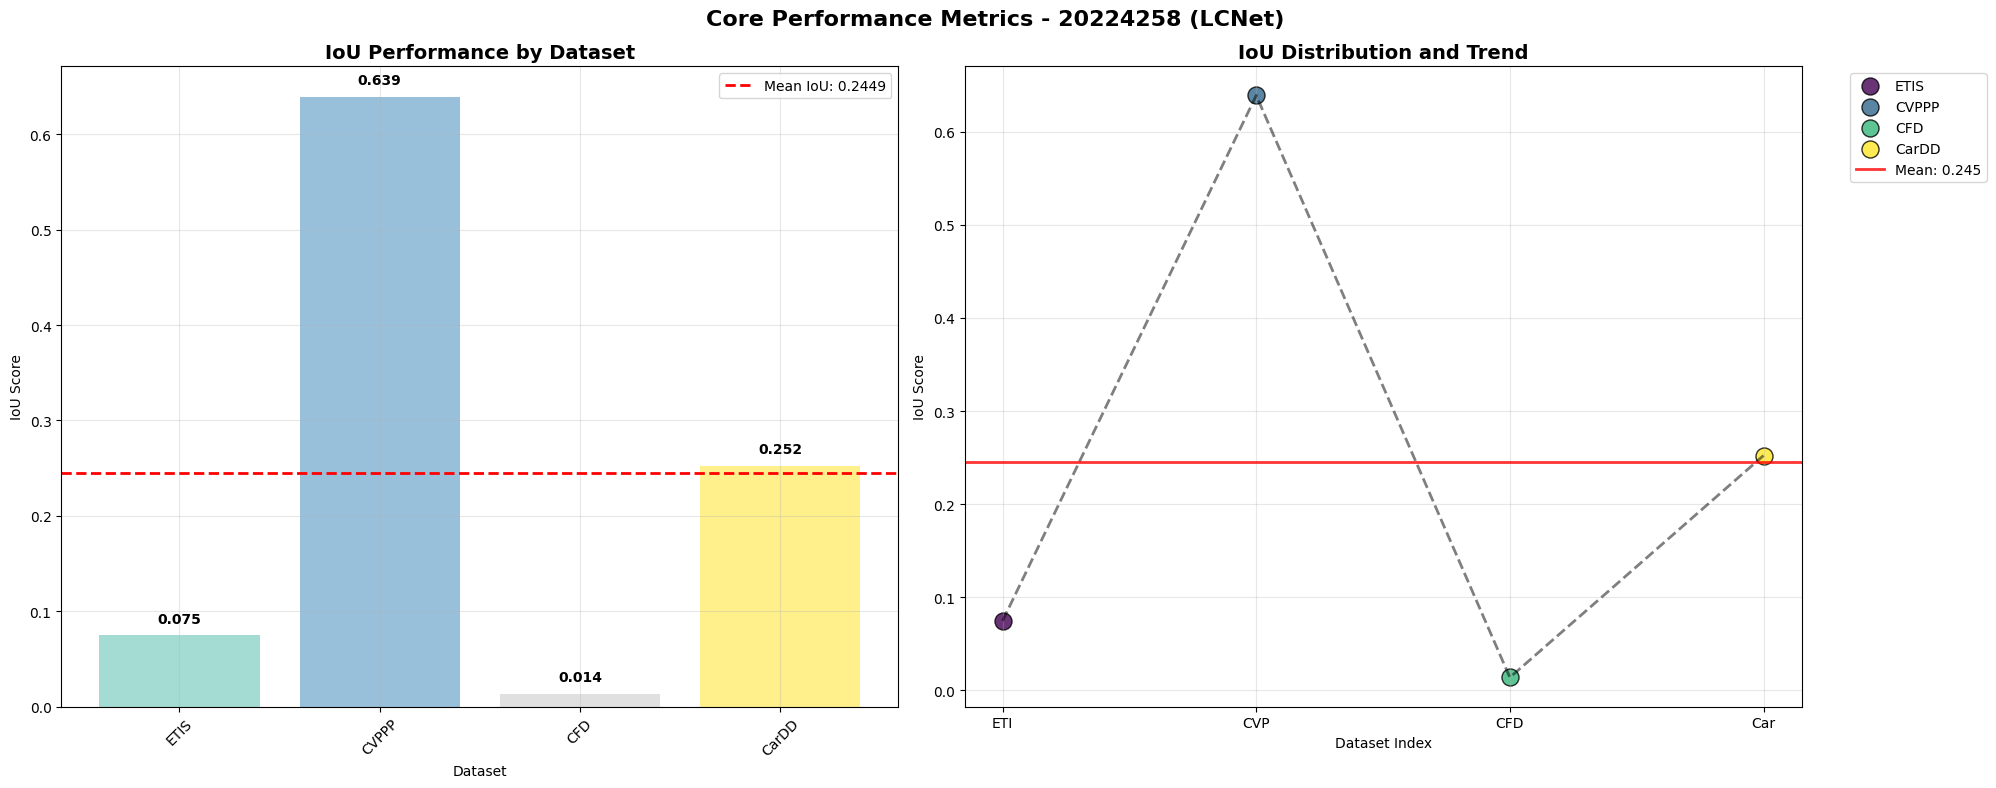

In [9]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

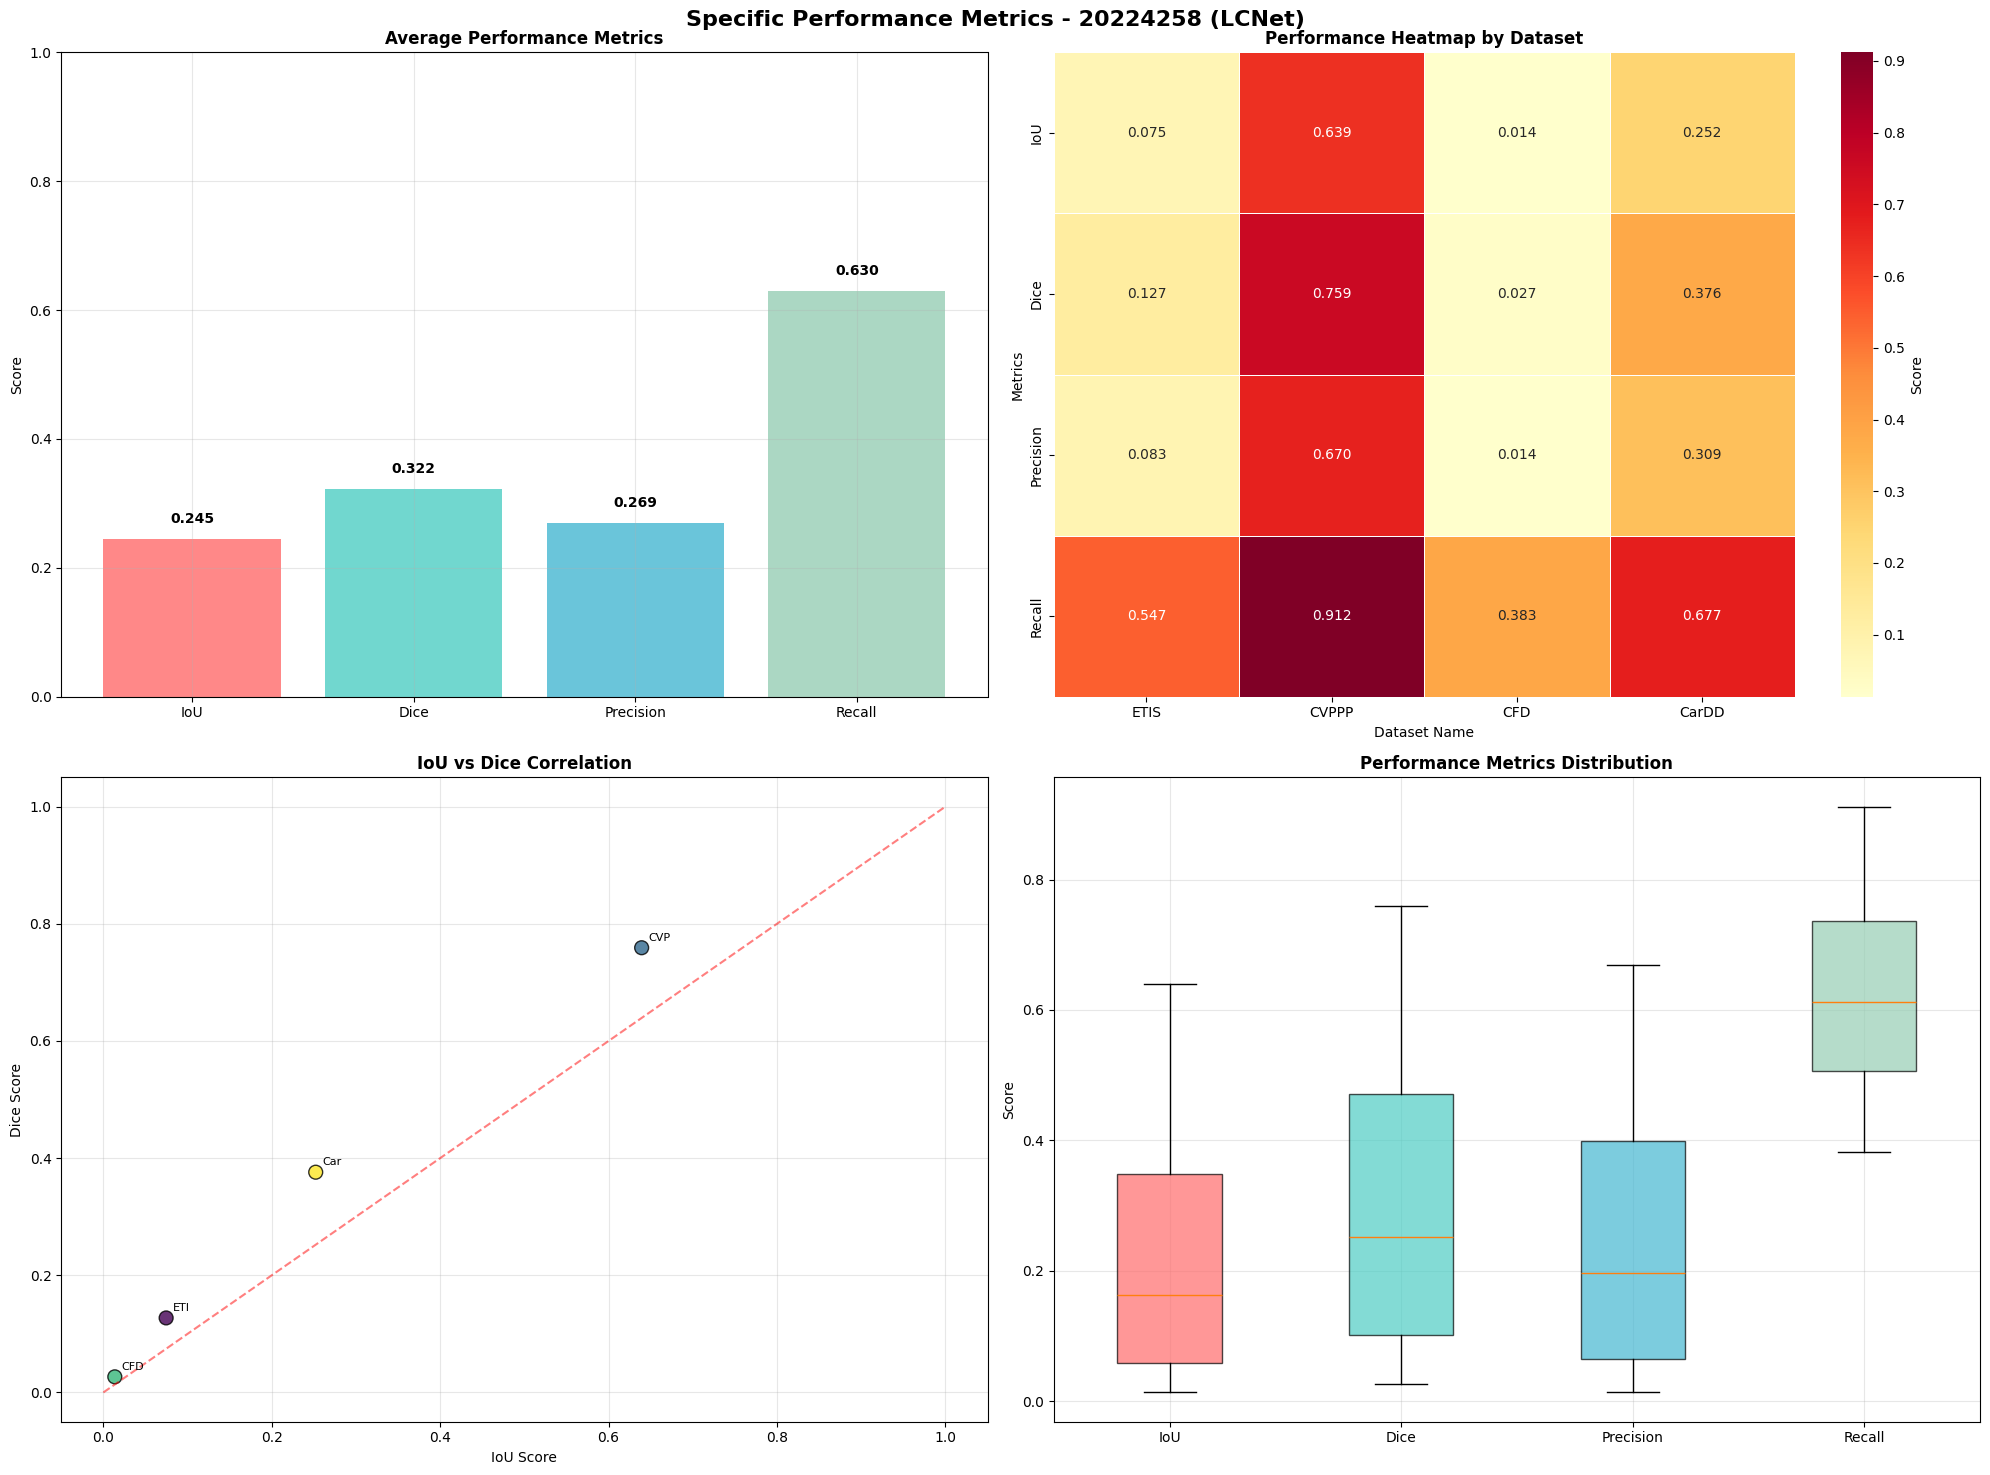

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [12]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250616_184055/experiment_summary_250616_184055.md
